# Лабораторная работа №2

Задание:

Провести эксперимент с деформацией моделей. В данном случае в качестве исходного приблежения взять модель сферы, а в качестве целевой модели выступает собственная модель.

## Импорт и установка необходимых библиотек

In [ ]:
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

In [ ]:
!pip install mesh_to_sdf pyrender trimesh

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install --upgrade setuptools wheel

In [ ]:
!pip install celluloid

In [ ]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes

# render
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader,
    PointLights
)

from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface

# trimesh lib imports
import trimesh

In [ ]:
from pytorch3d.renderer.mesh import Textures

In [ ]:
from tqdm import tqdm_notebook
from celluloid import Camera
from matplotlib import animation
from IPython.display import HTML

## Импорт модели

In [ ]:
# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

In [ ]:
path_to_model = os.path.join("Jess_Casual_Walking.obj")

In [ ]:
# Trimesh .obj model
jess_trimesh = trimesh.load(path_to_model)

if isinstance(jess_trimesh, trimesh.Scene):
    bunny_trimesh = jess_trimesh.dump(concatenate=True)

jess_trimesh.vertices -= jess_trimesh.center_mass
scaling = 2 / jess_trimesh.scale
jess_trimesh.apply_scale(scaling=scaling)

# Jess mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a meshes object for the Jess.
jess_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

## Импорт модели сферы

In [ ]:
# Trimesh sphere .obj model
trimesh_sphere = trimesh.primitives.Sphere(subdivisions= 4)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(4, device)

verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

In [ ]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

## Параметры оптимизационного процесса

In [ ]:
# Number of optimization steps
Niter = 3000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 50

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

## Градиентный спуск
В цикле происходит градиентный спуск по функции потерь, представляющей из себя взвешенную сумму функций ошибок регуляризаторов.

Для более лучшего понимания происходящего была реализована анимация.

In [ ]:
loop = tqdm_notebook(range(Niter))

fig = plt.figure()
camera = Camera(fig)

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(jess_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer.item())
    edge_losses.append(loss_edge.item())
    normal_losses.append(loss_normal.item())
    laplacian_losses.append(loss_laplacian.item())

    # Plot mesh
    if i % plot_period == 0 or i==0:

        # Render the bunny providing the values of R and T.
        image_jess = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_jess = image_jess.detach().cpu().numpy()

        plt.imshow(image_jess.squeeze())
        plt.grid(False)
        camera.snap()

    # Optimization step
    loss.backward()
    optimizer.step()

plt.close()

# Create animation
anim = camera.animate()

# Inline display
HTML(anim.to_html5_video())

<ipython-input-179-d44f57d370c5>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(Niter))


  0%|          | 0/3000 [00:00<?, ?it/s]

## Изменения функций потерь и регуляризаторов
Изображение, демонстрирующее изменения различных функций потерь и регуляризаторов в процессе обучения.

Text(0.5, 1.0, 'Loss vs iterations')

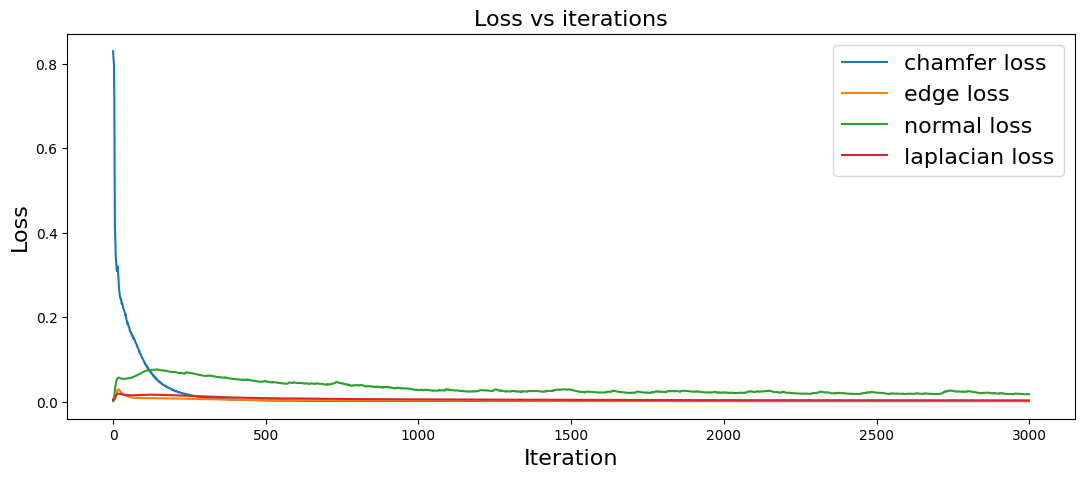

In [ ]:
# Losses evaluation
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")